Start By downloading the data as provided in the example colab

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd

from gensim.models import Word2Vec

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
#Seperate out the testing and training data
imdb, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
train_data, test_data = imdb['train'], imdb['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYSW0T3/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYSW0T3/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYSW0T3/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_df = tfds.as_dataframe(imdb['train'], info)

Look at the training data

In [4]:
train_df.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


Convert the text into useful tokens, we do this by getting rid of useless words standaradizing the words into lowercase and getting rid of punctuation

In [5]:
#Create the vectors
import string
vector_column = []
#go through every reveiw
for review in train_df.text:
  #convert it to a string
  review = str(review)
  #use the library to convert them into tokens which splits on spaces
  tokens = word_tokenize(review)
  #lowercase all the words
  tokens = [w.lower() for w in tokens]
  #get rid of punctuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #get rid of meaningless stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in stripped if not w in stop_words]
  #add all the words together
  vector_column.append(words)

In [6]:
train_df['tokens'] = vector_column
train_df.head()

,label,text,tokens
0,0,"b""This was an absolutely terrible movie. Don't...","[b, , absolutely, terrible, movie, , nt, lured..."
1,0,b'I have been known to fall asleep during film...,"[b, , known, fall, asleep, films, , usually, d..."
2,0,b'Mann photographs the Alberta Rocky Mountains...,"[bmann, photographs, alberta, rocky, mountains..."
3,1,b'This is the kind of film for a snowy Sunday ...,"[bthis, kind, film, snowy, sunday, afternoon, ..."
4,1,"b'As others have mentioned, all the women that...","[bas, others, mentioned, , women, go, nude, fi..."


In [7]:
#create a word to vec model which can convert the words we need to a vec
encoding_column = []
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


#Create a model using genism Word2Vec with the sentences that we just got from our dataset and for each word make a vector of size 100
model = Word2Vec(sentences=train_df.tokens, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")


In [17]:
encoding_column = []
#for every one of these token arrays that we made
for token_array in train_df.tokens:
  review_vector = []
  tokens = token_array
  #add the vector that we w2vectored to a list
  if len(tokens)>75:
    for token in tokens[:75]:
      review_vector.append(model.wv[token])
    #convert everything to numpy array
    review_vector = np.asarray(review_vector)
    #add the vectors to another dimension
    encoding_column.append(review_vector)
  else:
    for token in tokens:
      review_vector.append(model.wv[token])
    #deal with the case of too short reveiw
    for i in range(75-len(tokens)):
        review_vector.append(np.zeros(100))
    #convert everything to numpy array
    review_vector = np.asarray(review_vector)
    #add the vectors to another dimension
    encoding_column.append(review_vector)
encoding_column = np.asarray(encoding_column)
print(encoding_column.shape)


(25000, 75, 100)


In [18]:
#set our training data 
X_train = encoding_column
Y_train = np.asarray(train_df['label']).astype(np.float32)
print(Y_train.size)

25000


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

#The input is are these vectors of average vecotors of words
number_of_features = len(encoding_column[0])
print(number_of_features)
s_model = Sequential()

#Tell the model we want to use the relu function to map our data
#Add one layer of 100 nodes and maintain the activation as sigmoid
s_model.add(LSTM(100,input_shape = (75,100)))
#add the output layer with 2 outputs representing 0 or 1 because we are making a binary classifier
#The activation must be sigmoid because it is a binary classifier
s_model.add(Dense(1, activation = 'sigmoid'))


#Set gradient desent and find the linear regression with a given loss function of binary cross entrapy
s_model.compile(loss='binary_crossentropy', metrics = ['accuracy'])
#actually perform the gradient desent over 20 epochs with a batch_size of 200 on the training data

history = s_model.fit(X_train, Y_train, epochs=20, batch_size = 200)

75
Epoch 1/20
125/125 [==============================] - 32s 239ms/step - loss: 0.5750 - accuracy: 0.7001
Epoch 2/20
125/125 [==============================] - 30s 240ms/step - loss: 0.4875 - accuracy: 0.7721
Epoch 3/20
125/125 [==============================] - 31s 246ms/step - loss: 0.4489 - accuracy: 0.7907
Epoch 4/20
125/125 [==============================] - 31s 248ms/step - loss: 0.4236 - accuracy: 0.8052
Epoch 5/20
125/125 [==============================] - 30s 239ms/step - loss: 0.4059 - accuracy: 0.8160
Epoch 6/20
125/125 [==============================] - 30s 239ms/step - loss: 0.3915 - accuracy: 0.8216
Epoch 7/20
125/125 [==============================] - 32s 256ms/step - loss: 0.3782 - accuracy: 0.8307
Epoch 8/20
125/125 [==============================] - 30s 239ms/step - loss: 0.3687 - accuracy: 0.8362
Epoch 9/20
125/125 [==============================] - 30s 240ms/step - loss: 0.3599 - accuracy: 0.8399
Epoch 10/20
125/125 [==============================] - 32s 254ms/step 

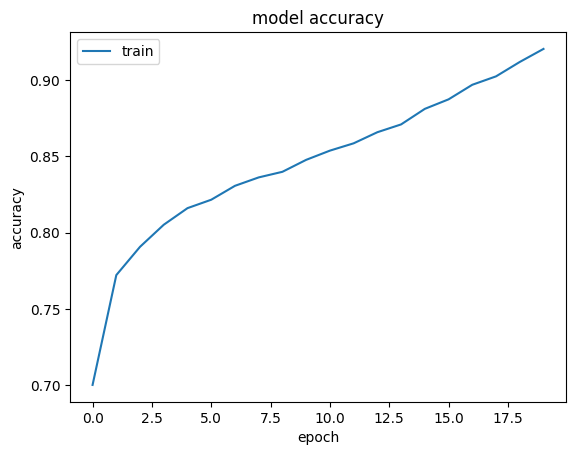

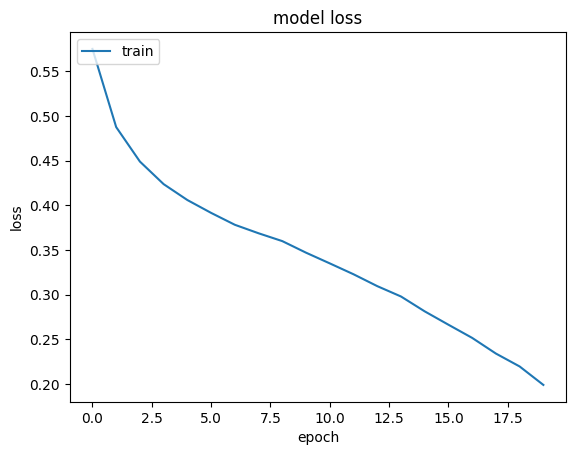

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
test_df = tfds.as_dataframe(imdb['test'], info)

In [25]:
#tokenize the testing data
import string
vector_column = []
for review in test_df.text:
  review = str(review)
  tokens = word_tokenize(review)
  tokens = [w.lower() for w in tokens]

  
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]

  stop_words = set(stopwords.words('english'))
  words = [w for w in stripped if not w in stop_words]
  vector_column.append(words)

test_df['tokens'] = vector_column
test_df.head()

,label,text,tokens
0,1,"b""There are films that make careers. For Georg...","[b, , films, make, careers, , george, romero, ..."
1,1,"b""A blackly comic tale of a down-trodden pries...","[b, , blackly, comic, tale, downtrodden, pries..."
2,0,"b'Scary Movie 1-4, Epic Movie, Date Movie, Mee...","[bscary, movie, 14, , epic, movie, , date, mov..."
3,0,b'Poor Shirley MacLaine tries hard to lend som...,"[bpoor, shirley, maclaine, tries, hard, lend, ..."
4,1,b'As a former Erasmus student I enjoyed this f...,"[bas, former, erasmus, student, enjoyed, film,..."


In [39]:
encoding_column = []
#for every one of these token arrays that we made
for token_array in test_df.tokens:
  review_vector = []
  tokens = token_array
  #add the vector that we w2vectored to a list
  #only use the first 75 words of the reveiw, for the model there needs to be consistent size
  if len(tokens)>75:
    for token in tokens[:75]:
      #this if statement is important for when new words appear
      if token in model.wv.key_to_index:
        review_vector.append(model.wv[token])
      #pad them with the vecotor of a neutral word like blue
      else:
        review_vector.append(model.wv['blue'])
    #convert everything to numpy array
    review_vector = np.asarray(review_vector)
    #add the vectors to another dimension
    encoding_column.append(review_vector)
  #in the case of a very short reveiw
  else:
    #use all the words
    for token in tokens[:75]:
      #this if statement is important for when new words appear
      if token in model.wv.key_to_index:
          review_vector.append(model.wv[token])
      else:
          review_vector.append(model.wv['blue'])
      #deal with the case of too short reveiw just pad zeros
    for i in range(75-len(tokens)):
        review_vector.append(np.zeros(100))
    #convert everything to numpy array
    review_vector = np.asarray(review_vector)
    #add the vectors to another dimension
    encoding_column.append(review_vector)
encoding_column = np.asarray(encoding_column)
print(encoding_column.shape)


(25000, 75, 100)


In [40]:
X_test = encoding_column
Y_test = np.asarray(test_df['label']).astype(np.float32)
print(X_test.shape)

(25000, 75, 100)


In [41]:
test_results = s_model.evaluate(X_test, Y_test)
print(test_results)

782/782 [==============================] - 20s 25ms/step - loss: 0.5381 - accuracy: 0.8039
[0.5381414890289307, 0.8039199709892273]


In [42]:
#Make predictions for the test dataset
y_prediction = s_model.predict(X_test)
#Convert to a classification prediciton either 0 or 1
y_prediction_class = np.round(y_prediction)
print(y_prediction_class)
print(Y_test)

782/782 [==============================] - 20s 25ms/step
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]
[1. 1. 0. ... 0. 1. 1.]


In [43]:
from sklearn.metrics import mean_squared_error, r2_score, recall_score, precision_score, accuracy_score

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_prediction_class))
# The recall
print("Recall: %.2f" % recall_score(Y_test, y_prediction_class))
# The precision
print("Precision: %.2f" % precision_score(Y_test, y_prediction_class))
# The accuracy
print("Accuracy: %.2f" % accuracy_score(Y_test, y_prediction_class))


Mean squared error: 0.20
Recall: 0.78
Precision: 0.82
Accuracy: 0.80


In [44]:
test_df.text[0]#The model says the is negative but it is labeled as positive, I am not sure why the model predicts this so poorly

b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."